### Carregamento dos dados

In [1]:
import pandas as pd

TRAIN_DATASET_PATH = "../datasets/nodelay_train.csv"
#TRAIN_DATASET_PATH = "../datasets/meds_train_alunos.csv"
TEST_DATASET_PATH = "../datasets/nodelay_teste.csv"
BTS_DATASET = "../datasets/Bts.csv"

In [2]:
df_train = pd.read_csv(TRAIN_DATASET_PATH)
df_train.head()

,rssi_1_1,rssi_1_2,rssi_1_3,rssi_2_1,rssi_2_2,rssi_2_3,rssi_3_1,rssi_3_2,rssi_3_3,dist_min_1,dist_max_1,dist_min_2,dist_max_2,dist_min_3,dist_max_3,indoor,lat,lon
0,-0.905471,-1.086213,-1.318039,-0.988866,-1.698103,-1.545878,-1.893147,-1.057385,-1.153863,0.529568,0.529568,-0.225214,-0.225214,-0.50175,-0.50175,1,-8.055786,-34.951505
1,-1.058857,-1.525950,-1.093259,-1.309425,-1.410700,-2.484693,0.338785,-0.137486,-0.590159,0.529568,0.529568,-0.225214,-0.225214,-0.50175,-0.50175,1,-8.055784,-34.951608
2,-0.794973,-1.525950,-0.696830,-1.309425,-1.234365,-0.515525,-0.677829,-0.767918,-1.153863,0.529568,0.529568,-0.225214,-0.225214,-0.50175,-0.50175,1,-8.055506,-34.951693
3,0.564307,0.179995,0.828553,-0.007743,-0.352404,0.031466,0.536692,-1.121926,1.118159,-0.300869,-0.300869,2.618453,2.618453,-0.50175,-0.50175,0,-8.050390,-34.959630
4,-1.448712,-0.776235,-1.279569,-0.858446,-1.297423,-0.970501,-1.404750,-1.056249,-1.153863,0.529568,0.529568,-0.225214,-0.225214,-0.50175,-0.50175,1,-8.055380,-34.951736


### Trilateração com KNN

In [3]:
# Imports
import pandas as pd
import numpy as np
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# Definições iniciais mockadas
# Setando as coordenadas (latitude e longitude) das 3 estações
bts_coords = [
    [-8.04342, -34.952, 1],  # BTS 1
    [-8.05289, -34.944672, 1],  # BTS 2
    [-8.05532, -34.957900, 1]  # BTS 3
]

# Adiciona no nosso df de treino 
# as distancias euclidianas de cada ponto (lat, lon) até as BTSs
def dist(df, bts_coords):
    for index, (lat, lon, _) in enumerate(bts_coords, start=1):
        col_name = f'bts_{index}_dist'
        df[col_name] = np.sqrt((df['lat'] - lat)**2 + (df['lon'] - lon)**2)
    return df

# Alterando o df_train para conformar de acordo com dist
train = dist(df_train, bts_coords)

def knn_regression_and_return_best_model(df, k_values, bts_id):
    X = df[['rssi_1_{}'.format(bts_id), f'dist_min_{bts_id}',f'dist_max_{bts_id}']]
    y = df[f'bts_{bts_id}_dist']

    # dividindo o conjunto de dados em treino e teste
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Melhor modelo - vai ser definido 
    best_knn = None
    # score Rˆ2
    best_score = -np.inf
    best_k = 0

    for k in k_values:
        knn = KNeighborsRegressor(n_neighbors=k)
        knn.fit(X_train, y_train)
        score = knn.score(X_test, y_test)
        if score > best_score:
            best_knn = knn
            best_score = score
            best_k = k

    # Plotting
    y_pred = best_knn.predict(X_test)
    plt.scatter(y_test, y_pred, alpha=0.6)
    plt.xlabel('Valores Reais'+ "best k:"+str(best_k))
    plt.ylabel('Previsões')
    plt.title(f'Previsões vs. Valores Reais para BTS {bts_id}')
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
    plt.show()

    return best_knn


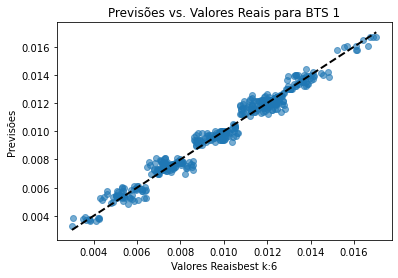

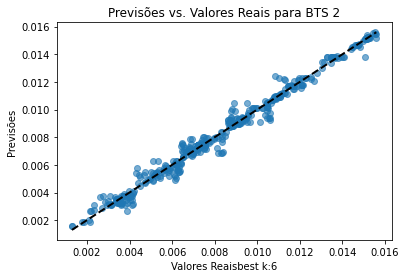

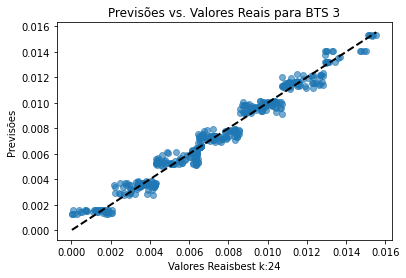

In [4]:
# Exemplo de uso para as BTSs 1, 2 e 3 mockadas
# Armazenando os melhores modelos
models = []
k_values = [i for i in range(2, 30,2)]
for bts_id in range(1, 4):
    model = knn_regression_and_return_best_model(train, k_values, bts_id)
    models.append(model)

#### Função Trilateração

In [5]:
def trilateration(bts1_pos, bts2_pos, bts3_pos, dist_to_bts1, dist_to_bts2, dist_to_bts3):
    # Ajusta as posições das BTSs para o sistema de coordenadas centrado na BTS1
    p2 = np.array(bts2_pos) - np.array(bts1_pos)
    p3 = np.array(bts3_pos) - np.array(bts1_pos)

    # Calcula os vetores e suas normalizações - formando nossa base ortonormal
    # Cada vetor é unitário e os 3 são mutuamente perpendiculares
    Xn = p2 / np.linalg.norm(p2)
    Zn = np.cross(p2, p3) / np.linalg.norm(np.cross(p2, p3))
    Yn = np.cross(Xn, Zn)

    # Projeções no sistema de coordenadas local
    i = np.dot(Xn, p3)
    d = np.linalg.norm(p2)
    j = np.dot(Yn, p3)

    # Cálculo de X
    X = (pow(dist_to_bts1, 2) - pow(dist_to_bts2, 2) + pow(d, 2)) / (2 * d)
    # Cálculo de Y
    Y = ((pow(dist_to_bts1, 2) - pow(dist_to_bts3, 2) + pow(i, 2) + pow(j, 2)) / (2 * j)) - ((i / j) * X)
    # Cálculo de Z
    Z = np.sqrt(max(0, pow(dist_to_bts1, 2) - pow(X, 2) - pow(Y, 2)))

    # Transforma de volta para o sistema de coordenadas global, considerando a posição da BTS1 como referência
    estimated_pos = np.array(bts1_pos) + X * Xn + Y * Yn + Z * Zn
    return estimated_pos


In [8]:
import numpy as np

def predict_distance(model, rssi, dist_min, dist_max):
    return model.predict(np.array([[rssi, dist_min,dist_max]]))[0]

def prev_loc(rssi_values, delay_values, models, bts_positions):
    predicted_distances = []
    for i, model in enumerate(models):
        # features = np.array([[rssi_values[i], delay_values[i]]]) 
        features_df = pd.DataFrame(data=[[rssi_values[i], delay_values[i][0], delay_values[i][1]]], columns=['rssi_1_{}'.format(i+1), 'dist_min_{}'.format(i+1), 'dist_max_{}'.format(i+1)])


        predicted_distance = model.predict(features_df)[0]
        predicted_distances.append(predicted_distance)
    return trilateration(bts_positions[0], bts_positions[1], bts_positions[2], *predicted_distances)

In [9]:
# Separando características (X) e alvos (y)
X = train.iloc[:, :-5]  # Seleciona todas as colunas exceto as seis últimas (lat, lon, indoor, dist_1, dist_2, dist_3)
y = train.iloc[:, -5:-3]  # Seleciona apenas as colunas 'lat' e 'lon' como as colunas que precisamos prever 

# # Dividindo os dados em conjuntos de treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# # Inicializando listas para previsões e valores verdadeiros
lat_pred = []
lon_pred = []

lat_true = y_test['lat'].values  
lon_true = y_test['lon'].values  

for index, row in X_test.iterrows():
    rssi_values = [row[f'rssi_{i}_2'] for i in range(1, 4)]  
    delay_values = [[row['dist_min_1'],row['dist_max_1']], [row['dist_min_2'],row['dist_max_2']], [row['dist_min_3'],row['dist_max_3']]]  

    pred = prev_loc(rssi_values, delay_values, models, bts_coords) 

    lat_pred.append(pred[0])
    lon_pred.append(pred[1])

In [10]:
X_test_reset = X_test.reset_index(drop=True)
X_test_reset.head()

,rssi_1_1,rssi_1_2,rssi_1_3,rssi_2_1,rssi_2_2,rssi_2_3,rssi_3_1,rssi_3_2,rssi_3_3,dist_min_1,dist_max_1,dist_min_2,dist_max_2,dist_min_3,dist_max_3,indoor
0,-1.303568,-1.525950,-0.404943,-1.309425,-0.566239,-0.569746,-0.949603,-0.861263,-1.153863,0.529568,0.529568,-0.225214,-0.225214,0.190417,0.190417,1
1,0.812406,0.954700,0.630561,1.671013,1.072301,0.952421,0.230075,0.149116,0.300051,-0.300869,-0.300869,-1.647048,-1.647048,0.882584,0.882584,0
2,0.928598,0.037192,1.216997,-0.034856,-0.215573,-0.144911,-0.156979,1.706910,0.395504,0.529568,0.529568,1.196620,1.196620,-1.886085,-1.886085,0
3,-0.405252,-0.736827,-0.410119,0.060671,0.471732,0.115508,-0.947811,-0.337552,-1.153863,0.529568,0.529568,-0.225214,-0.225214,0.190417,0.190417,1
4,-0.248753,1.251840,-0.123998,0.320137,0.088433,-0.511538,-0.006458,-0.307214,0.164246,-1.131305,-1.131305,-0.936131,-0.936131,1.574752,1.574752,0


In [11]:
import folium
mean_lat = (max(y_train['lat'].values.astype(float)) + min(y_train['lat'].values.astype(float))) / 2
mean_lon = (max(y_train['lon'].values.astype(float)) + min(y_train['lon'].values.astype(float))) / 2
m = folium.Map(location=[mean_lat, mean_lon], zoom_start=15)

for id in range(len(lat_pred)):
    folium.Marker([lat_true[id], lon_true[id]], icon=folium.Icon(color='green'), popup=f"Lat: {float(lat_true[id])} Lon: {float(lon_true[id])}").add_to(m)
    folium.Marker([lat_pred[id], lon_pred[id]], icon=folium.Icon(color='orange'), popup=f"Lat: {float(lat_pred[id])} Lon: {float(lon_pred[id])}").add_to(m)
    folium.PolyLine(locations=[[lat_pred[id],lon_pred[id]], [lat_true[id], lon_true[id]]], color='blue').add_to(m)

m.save('knn_nodelay.html')

#### Histograma

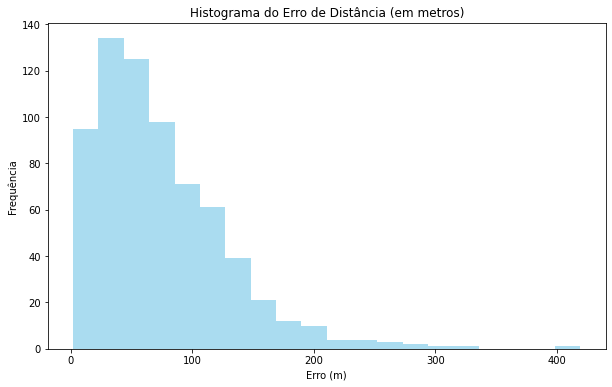

In [12]:
import numpy as np
import matplotlib.pyplot as plt

def haversine(lat1, lon1, lat2, lon2):
    R = 6371000  # Raio da Terra em metros
    phi1 = np.radians(lat1)
    phi2 = np.radians(lat2)
    delta_phi = np.radians(lat2 - lat1)
    delta_lambda = np.radians(lon2 - lon1)
    a = np.sin(delta_phi/2)**2 + np.cos(phi1) * np.cos(phi2) * np.sin(delta_lambda/2)**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1-a))
    distance = R * c
    return distance

# Usando Haversine para calcular erros em metros e não em graus
erros = [haversine(lat_true[i], lon_true[i], lat_pred[i], lon_pred[i]) for i in range(len(lat_true))]

# Plotando o histograma dos erros
plt.figure(figsize=(10, 6))
plt.hist(erros, bins=20, color='skyblue', alpha=0.7)
plt.title('Histograma do Erro de Distância (em metros)')
plt.xlabel('Erro (m)')
plt.ylabel('Frequência')
plt.show()


#### Boxplot

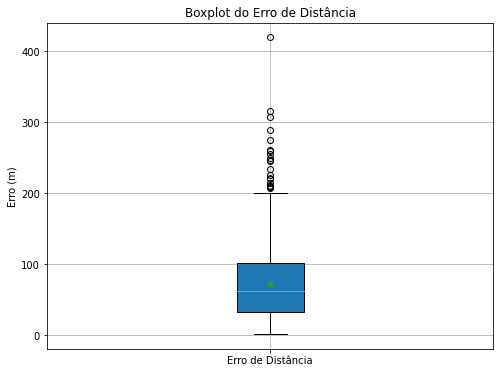

In [13]:
import matplotlib.pyplot as plt
import numpy as np

# Usando Haversine para calcular erros em metros e não em graus
erros = [haversine(lat_true[i], lon_true[i], lat_pred[i], lon_pred[i]) for i in range(len(lat_true))]

# Plotando o boxplot dos erros
plt.figure(figsize=(8, 6))
plt.boxplot(erros, vert=True, patch_artist=True, showmeans=True)
plt.title('Boxplot do Erro de Distância')
plt.ylabel('Erro (m)')
plt.xticks([1], ['Erro de Distância'])
plt.grid(True)
plt.show()


#### Estatísticas Básicas

In [14]:
import numpy as np

# Calculando estatísticas básicas dos erros
media_erro = np.mean(erros)
mediana_erro = np.median(erros)
desvio_padrao_erro = np.std(erros)
min_erro = np.min(erros)
max_erro = np.max(erros)
q1_erro = np.percentile(erros, 25)
q3_erro = np.percentile(erros, 75)

# Exibindo as estatísticas
print(f"Média do Erro: {media_erro:.2f} metros")
print(f"Mediana do Erro: {mediana_erro:.2f} metros")
print(f"Desvio Padrão do Erro: {desvio_padrao_erro:.2f} metros")
print(f"Mínimo Erro: {min_erro:.2f} metros")
print(f"Máximo Erro: {max_erro:.2f} metros")

Média do Erro: 74.24 metros
Mediana do Erro: 62.02 metros
Desvio Padrão do Erro: 54.41 metros
Mínimo Erro: 2.07 metros
Máximo Erro: 419.19 metros


### Resultado

In [15]:
df_test = pd.read_csv(TEST_DATASET_PATH)
df_test.head()

,rssi_1_1,rssi_1_2,rssi_1_3,rssi_2_1,rssi_2_2,rssi_2_3,rssi_3_1,rssi_3_2,rssi_3_3,dist_min_1,dist_max_1,dist_min_2,dist_max_2,dist_min_3,dist_max_3,ponto_id
0,-2.045268,-1.52595,-2.106583,-1.309425,-2.460121,-2.484693,0.044911,0.988675,-1.153863,0.529568,0.529568,-0.225214,-0.225214,-0.50175,-0.50175,0
1,-2.045268,-1.52595,-2.106583,-1.309425,-2.460121,-2.484693,0.044911,0.988675,-1.153863,0.529568,0.529568,-0.225214,-0.225214,-0.50175,-0.50175,3
2,-2.045268,-1.52595,-2.106583,-1.309425,-2.460121,-2.484693,0.044911,0.764071,-1.153863,0.529568,0.529568,-0.225214,-0.225214,-0.50175,-0.50175,8
3,-2.045268,-1.52595,-2.106583,-1.309425,-2.460121,-2.484693,0.044911,0.988675,-1.153863,0.529568,0.529568,-0.225214,-0.225214,-0.50175,-0.50175,10
4,-2.045268,-1.52595,-2.106583,-1.309425,-2.460121,-2.484693,0.044911,0.988675,-1.153863,0.529568,0.529568,-0.225214,-0.225214,-0.50175,-0.50175,12


In [17]:
# # Inicializando listas para previsões e valores verdadeiros
lat_pred = []
lon_pred = []
ponto_id = []

for index, row in df_test.iterrows():
    rssi_values = [row[f'rssi_{i}_2'] for i in range(1, 4)]  
    delay_values = [[row['dist_min_1'],row['dist_max_1']], [row['dist_min_2'],row['dist_max_2']], [row['dist_min_3'],row['dist_max_3']]]

    pred = prev_loc(rssi_values, delay_values, models, bts_coords) 

    ponto_id.append(row["ponto_id"])
    lat_pred.append(pred[0])
    lon_pred.append(pred[1])

In [18]:
pd.DataFrame.from_dict(
    {
        "ponto_id": ponto_id,
        "lat_pred": lat_pred,
        "lon_pred": lon_pred
    }
).to_csv("../datasets/Resultados_Equipe2_KNN_nodelay.csv", index=False)